# Dataset - Bank Marketing
The [data](https://archive.ics.uci.edu/dataset/222/bank+marketing) is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

In [2]:
df = pd.read_csv('bank-additional-full.csv', sep=';',na_values='unknown')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## Input variables

### Bank Client Data
1. `age` (numeric)
2. `job` : type of job (categorical)
3. `marital` : marital status (categorical)
4. `education` (categorical)
5. `default`: has credit in default? (categorical)
6. `housing`: has housing loan? (categorical)
7. `loan`: has personal loan? (categorical)

### Related With The Last Contact Of The Current Campaign
8. `contact`: contact communication type (categorical) 
9. `month`: last contact month of year (categorical)
10.  `day_of_week`: last contact day of the week (categorical)
11.  `duration`: last contact duration, in seconds (numeric).

### Other attributes
12. `campaign`: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. `pdays`: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. `previous`: number of contacts performed before this campaign and for this client (numeric)
15. `poutcome`: outcome of the previous marketing campaign (categorical)

### Social And Economic Context Attributes
16. `emp.var.rate`: employment variation rate - quarterly indicator (numeric)
17. `cons.price.idx`: consumer price index - monthly indicator (numeric)     
18. `cons.conf.idx`: consumer confidence index - monthly indicator (numeric)     
19. `euribor3m`: euribor 3 month rate - daily indicator (numeric)
20. `nr.employed`: number of employees - quarterly indicator (numeric)

### Output variable (desired target)
21. `y` - has the client subscribed a term deposit? (binary: "yes","no")

# EDA and Data Preparation

In [3]:
print(df.shape)
print()
print(df.info())

(41188, 21)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             40858 non-null  object 
 2   marital         41108 non-null  object 
 3   education       39457 non-null  object 
 4   default         32591 non-null  object 
 5   housing         40198 non-null  object 
 6   loan            40198 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41

In [4]:
# For numerical columns
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [5]:
# For categorical columns
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,40858,41108,39457,32591,40198,40198,41188,41188,41188,41188,41188
unique,11,3,7,2,2,2,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


In [6]:
object_columns = df.select_dtypes(include=['object']).columns

for col in object_columns:
    print(f"Column: {col}")
    print(df[col].value_counts(dropna=False))
    print()

Column: job
job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
NaN                330
Name: count, dtype: int64

Column: marital
marital
married     24928
single      11568
divorced     4612
NaN            80
Name: count, dtype: int64

Column: education
education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
NaN                     1731
illiterate                18
Name: count, dtype: int64

Column: default
default
no     32588
NaN     8597
yes        3
Name: count, dtype: int64

Column: housing
housing
yes    21576
no     18622
NaN      990
Name: count, dtype: int64

Column: loan
loan
no     33950
yes     6248
NaN      990
Name: count, dtype: int64

Column:

### Removing Noise
I will delete `yes` option from `default` and `illiterate` from `education` as they don't give enough value and introduce noise.

In [7]:
df = df[df['education'] != 'illiterate']
df = df[df['default'] != 'yes']

### Duplicates
I will drop rows that are a duplicates of each others since they do not provide value for modeling.

In [8]:
df.drop_duplicates(inplace=True)
print(df.shape)

(41155, 21)


### `NaN`
Based on percentages - we can drop `NaN` from every column besides `default`. We are loosing about 7% from BIG dataset so it should be OK.

In [9]:
# How many NaN in each column - percentage
nan_percentage = df.isna().mean() * 100
print(nan_percentage[nan_percentage > 0])

job           0.801847
marital       0.194387
education     4.203620
default      20.869882
housing       2.405540
loan          2.405540
dtype: float64


In [10]:
# Drop nan from 'job' and 'marital' columns
df.dropna(subset=['job', 'marital','education','housing','loan'], inplace=True)
print(df.shape)

(38213, 21)


We go back to having `unknown` in `default` as a category

In [11]:
df.fillna({'default':'unknown'}, inplace=True)
print(df['default'].value_counts(dropna=False))

default
no         30464
unknown     7749
Name: count, dtype: int64


### `pdays`
Value of 999 means that there has been no contact with the client beforehand (in a previous campaign). Thus it makes sense to create a new binary column saying if there was a contact or not.

In [12]:
# Create a new column based on pdays column if there was a contact with the customer in previous campaign (every option besides 999) or not (999)
df['pdays_contact'] = df['pdays'].apply(lambda x: 1 if x != 999 else 0)
# Drop pdays column
df.drop(columns=['pdays'], inplace=True)

# Convert 'contacted' column to categorical
df['pdays_contact'] = df['pdays_contact'].astype('category')

In [13]:
# Mapping y to 1 and 0
df['y'] = df['y'].map({'yes': 1, 'no': 0})
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,pdays_contact
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38213 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             38213 non-null  int64   
 1   job             38213 non-null  object  
 2   marital         38213 non-null  object  
 3   education       38213 non-null  object  
 4   default         38213 non-null  object  
 5   housing         38213 non-null  object  
 6   loan            38213 non-null  object  
 7   contact         38213 non-null  object  
 8   month           38213 non-null  object  
 9   day_of_week     38213 non-null  object  
 10  duration        38213 non-null  int64   
 11  campaign        38213 non-null  int64   
 12  previous        38213 non-null  int64   
 13  poutcome        38213 non-null  object  
 14  emp.var.rate    38213 non-null  float64 
 15  cons.price.idx  38213 non-null  float64 
 16  cons.conf.idx   38213 non-null  float64 
 17  euribor3m       3

### `Duration`
The `duration` is not known before a call is performed. Also, after the end of the call `y` is obviously known. Thus, it should be discarded if the intention is to have a realistic predictive model.

In [15]:
# Drop the 'duration' column
df.drop(columns=['duration'], inplace=True)
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,pdays_contact
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,1,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1,0
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,1,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0,0
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,2,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0,0
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,1,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1,0


### Subscription rate
I check subscription rate to evaluate how strongly the category is connected to the getting a client to deposit. Based on the rate we can aggregate categories together.

In [16]:
categorical_features_to_analyze = [
    'job', 'marital', 'education', 'default', 'housing', 'loan', 
    'contact', 'month', 'day_of_week', 'poutcome', 'contacted'
]
numerical_features_to_analyze = [
    'age', 'campaign', 'previous', 'emp.var.rate', 
    'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'
]

# Categorical features vs target variable 'y'
for col in categorical_features_to_analyze:
    if col in df.columns:
        print(f"\n--- Impact of '{col}' for 'y' ---")
        
        # Group by category and calculate the mean of 'y' (percentage of 'yes')
        # and the number of observations in each category
        impact_df = df.groupby(col, observed=False)['y'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
        impact_df.rename(columns={'mean': 'subscription_rate', 'count': 'observations'}, inplace=True)
        
        print(impact_df)


--- Impact of 'job' for 'y' ---
               subscription_rate  observations
job                                           
student                 0.302326           688
retired                 0.246662          1573
unemployed              0.143451           962
admin.                  0.129065          9933
management              0.111437          2728
self-employed           0.107727          1346
technician              0.107154          6374
housemaid               0.099391           986
entrepreneur            0.084683          1358
services                0.079968          3714
blue-collar             0.069583          8551

--- Impact of 'marital' for 'y' ---
          subscription_rate  observations
marital                                  
single             0.136588         10755
divorced           0.103978          4299
married            0.100911         23159

--- Impact of 'education' for 'y' ---
                     subscription_rate  observations
education        

### Aggregation
Based on the values of `subscription_rate`:
- `education` -> combine `basic.4y`, `basic.6y`, `basic.9y` into one category called `basic_education`
- `marital` -> combine `divorced` and `married` into `married_or_divorced`
- `month` -> combine months based on the conversion rate

In [17]:
# Aggregate data from education column - categories 'basic.4y', 'basic.6y', 'basic.9y' into 'basic_education'
df['education'] = df['education'].replace({
    'basic.4y': 'basic_education', 
    'basic.6y': 'basic_education', 
    'basic.9y': 'basic_education'
})

In [18]:
# Aggregate data from marital column - categories 'divorced' and 'married' into married_or_divorced
df['marital'] = df['marital'].replace({
    'divorced': 'married_or_divorced', 
    'married': 'married_or_divorced'
})

In [19]:
# Aggregate month based on conversion rate
# March, December, October, and September - high conversion
# April - mid conversion
# June, August, November, July, and May - low conversion
df['month'] = df['month'].replace({
    'mar': 'high_conv', 
    'dec': 'high_conv', 
    'oct': 'high_conv', 
    'sep': 'high_conv', 
    'apr': 'mid_conv', 
    'jun': 'low_conv', 
    'aug': 'low_conv', 
    'nov': 'low_conv', 
    'jul': 'low_conv', 
    'may': 'low_conv'
})

### Visualizations

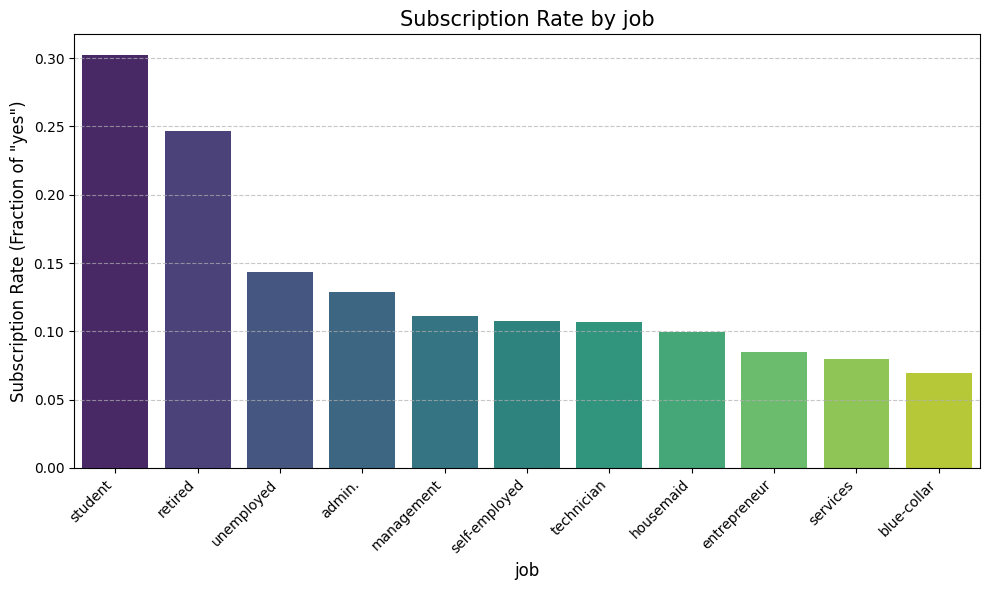

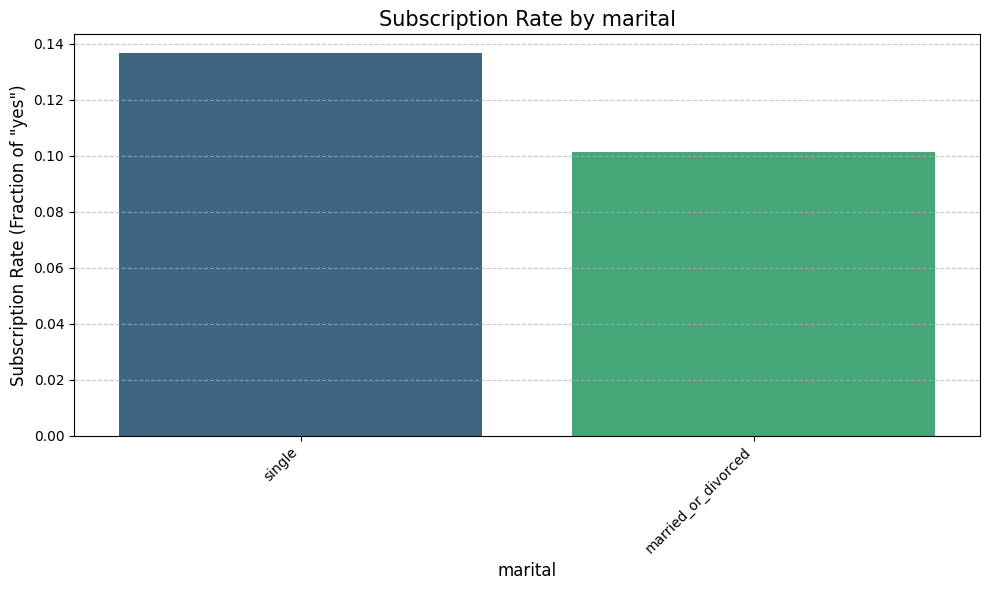

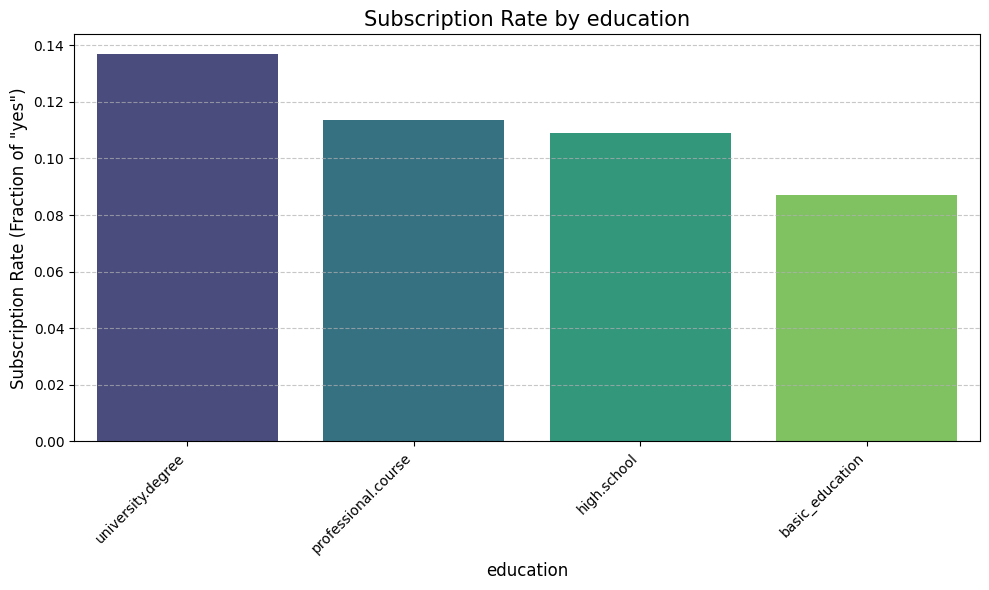

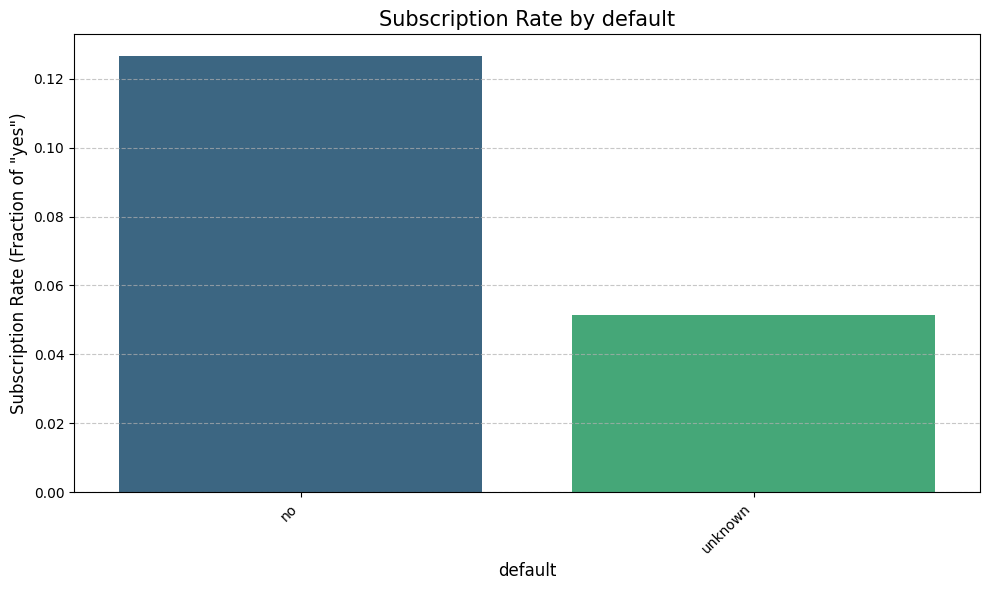

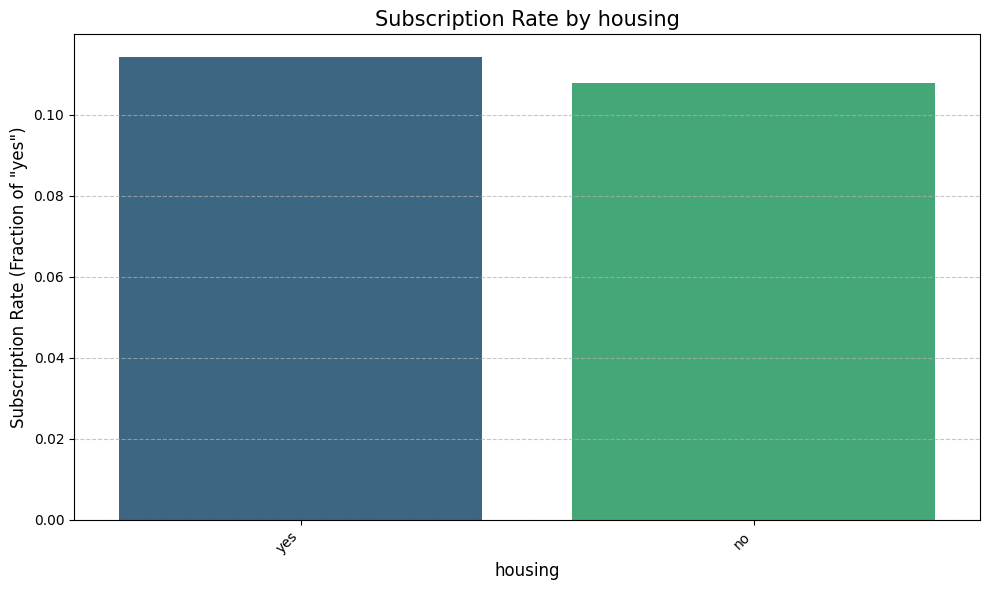

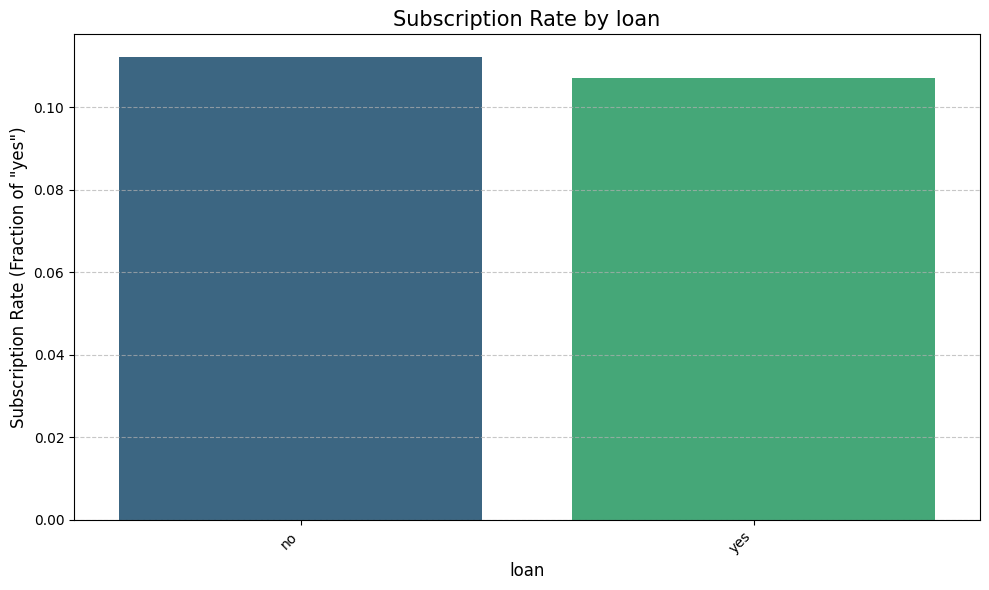

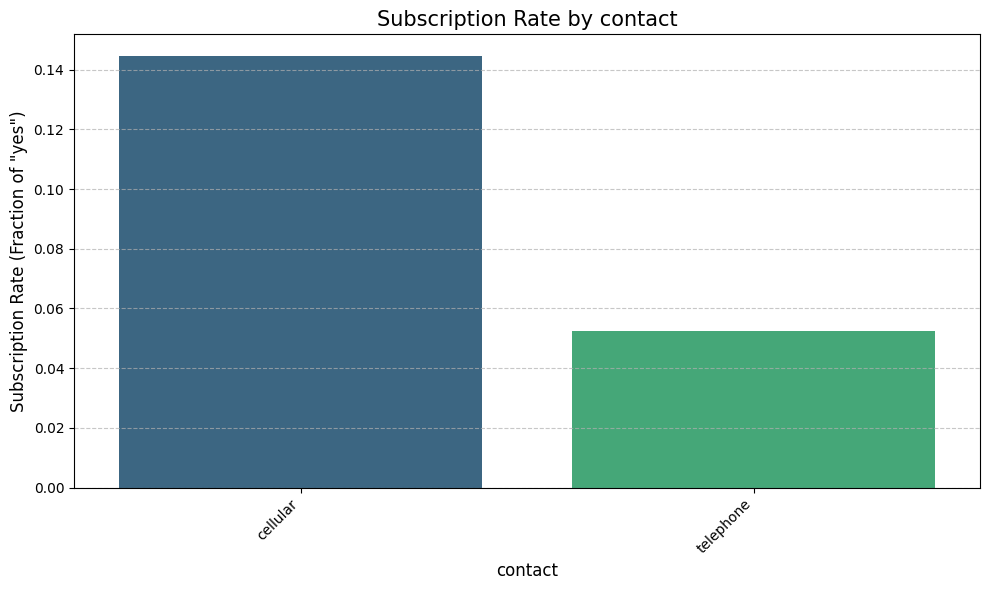

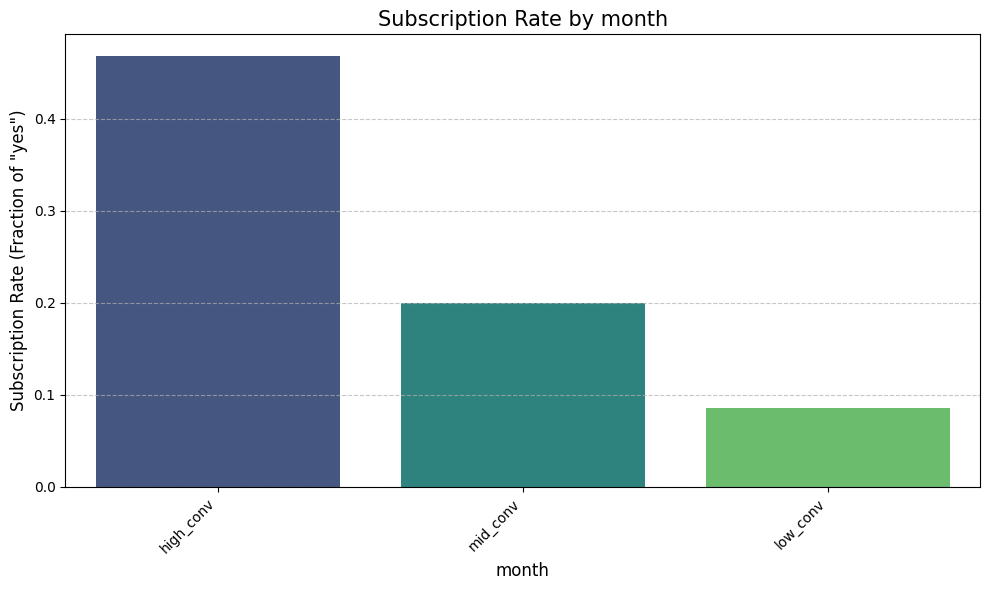

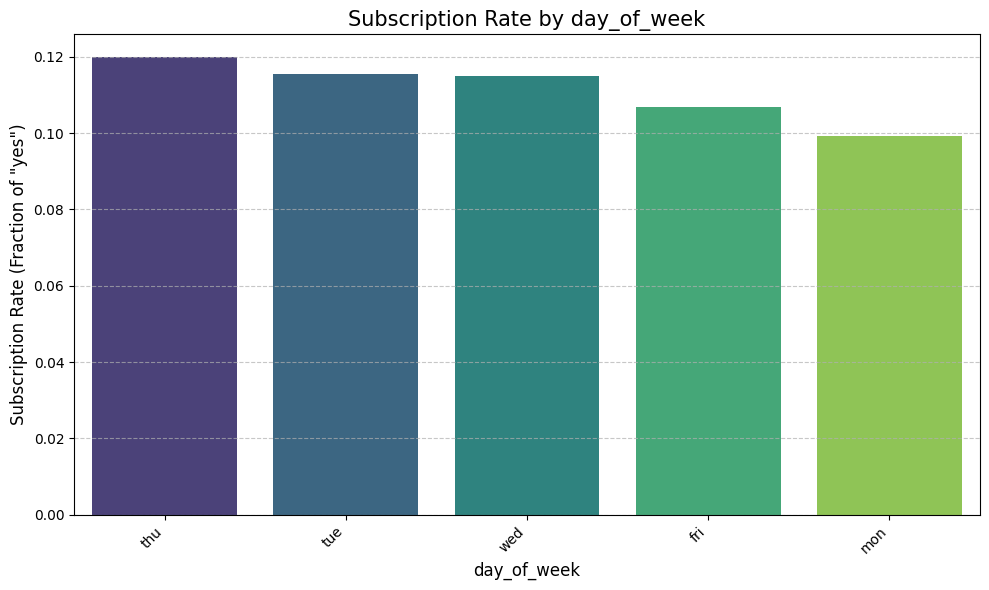

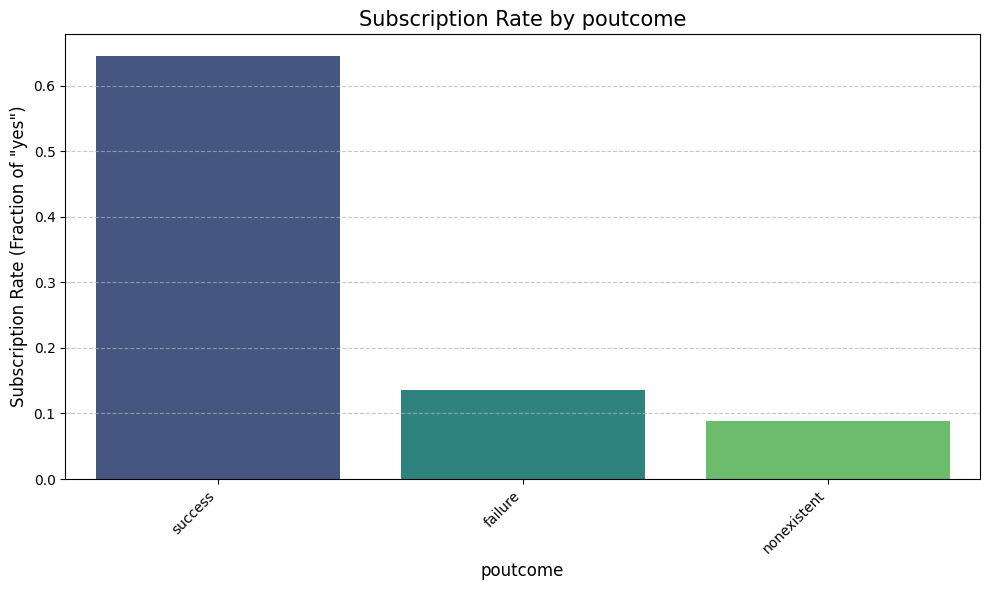

In [20]:
for col in categorical_features_to_analyze:
    if col in df.columns:
        impact_df = df.groupby(col, observed=False)['y'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
        impact_df.rename(columns={'mean': 'subscription_rate', 'count': 'observations'}, inplace=True)
        
        # Create a new figure for each plot
        plt.figure(figsize=(10, 6))
        sns.barplot(
            x=impact_df.index.astype(str), 
            y='subscription_rate', 
            data=impact_df.reset_index(), 
            hue=impact_df.index.astype(str),
            palette="viridis",
            legend=False
        )
        plt.title(f'Subscription Rate by {col}', fontsize=15)
        plt.ylabel('Subscription Rate (Fraction of "yes")', fontsize=12)
        plt.xlabel(col, fontsize=12)
        plt.xticks(rotation=45, ha="right", fontsize=10)
        plt.yticks(fontsize=10)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()


--- Impact of 'age' for 'y' ---


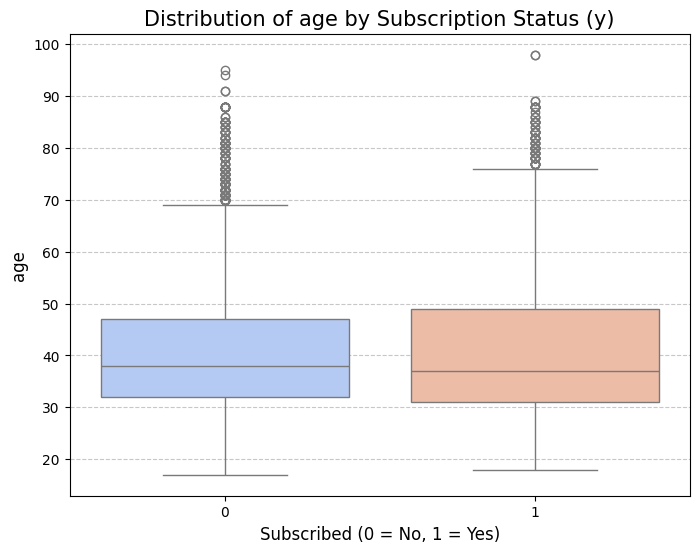

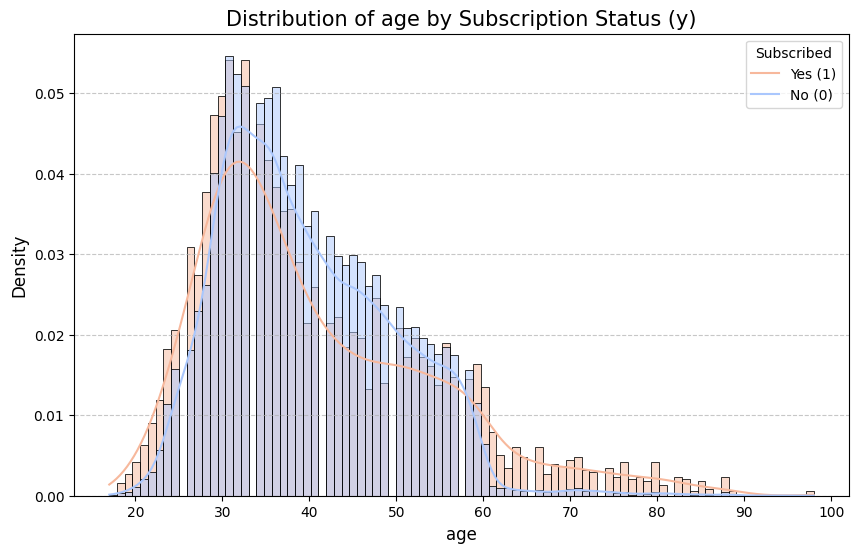


--- Impact of 'campaign' for 'y' ---


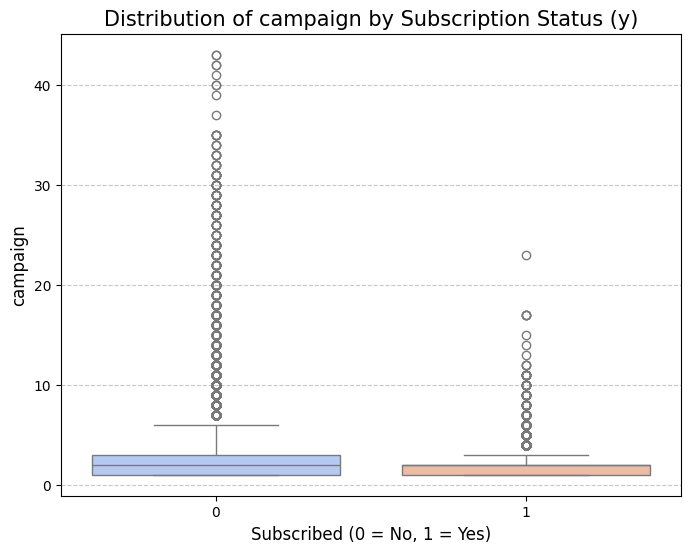

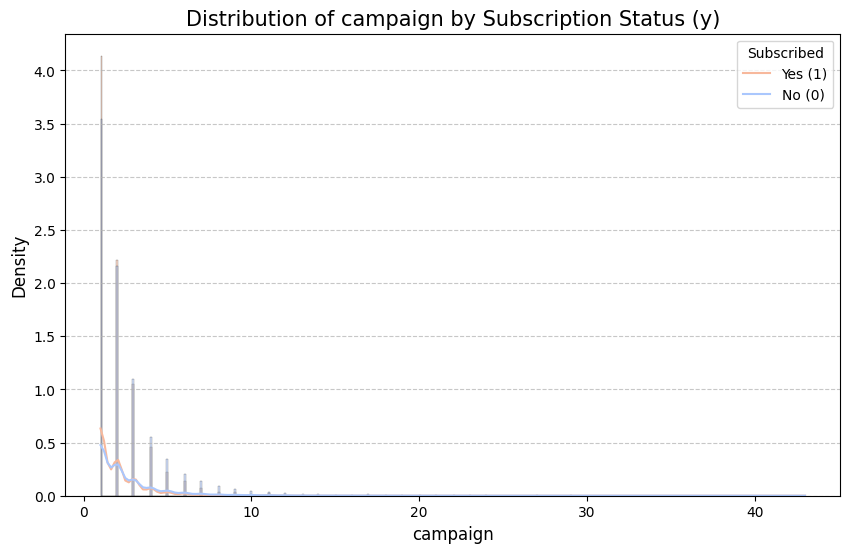


--- Impact of 'previous' for 'y' ---


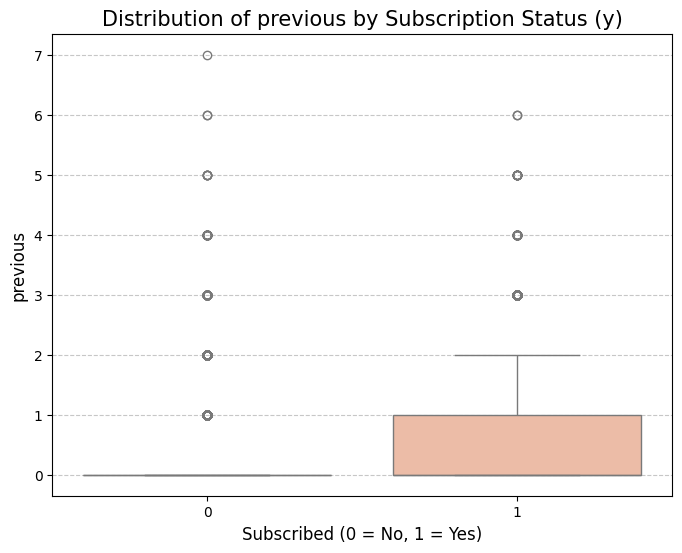

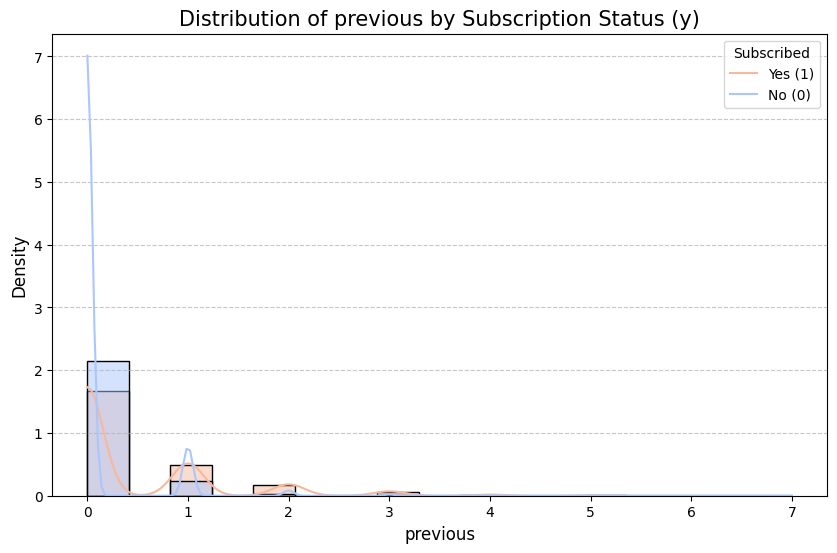


--- Impact of 'emp.var.rate' for 'y' ---


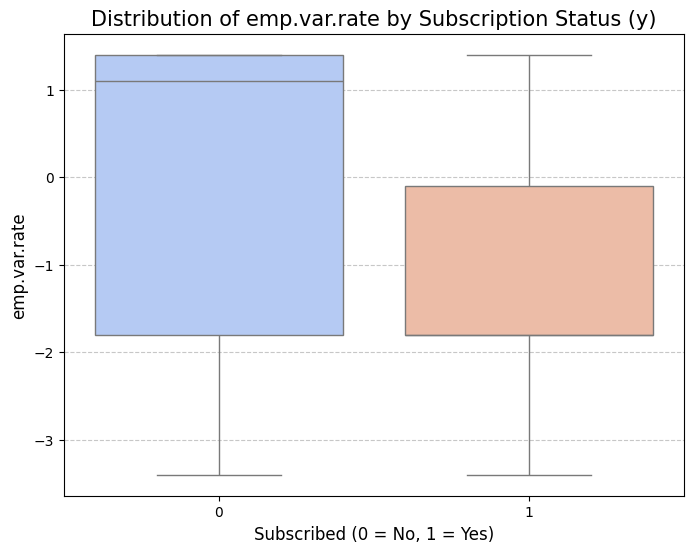

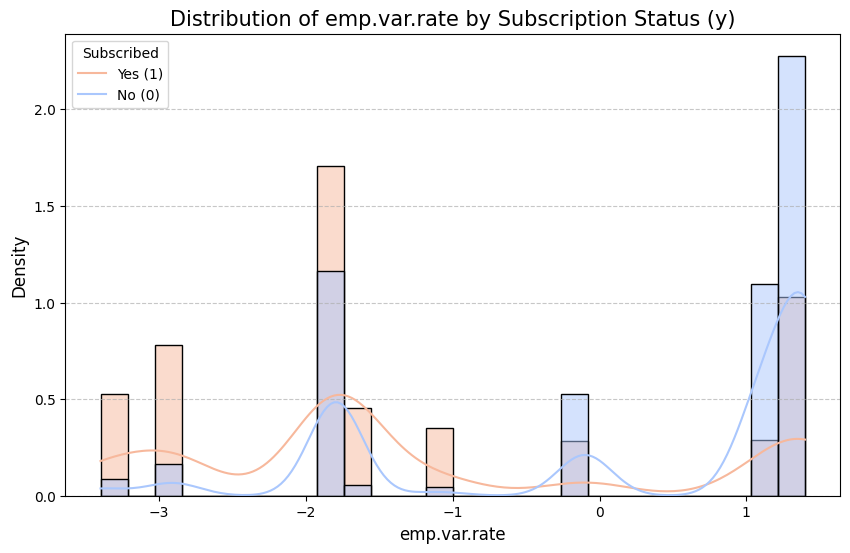


--- Impact of 'cons.price.idx' for 'y' ---


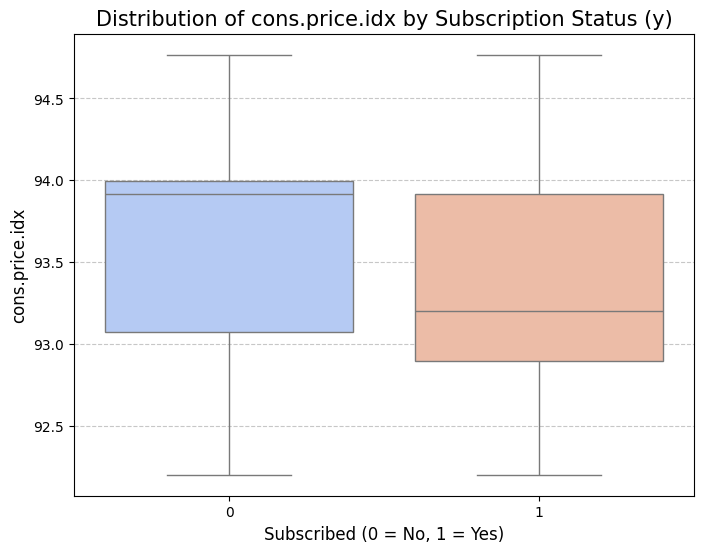

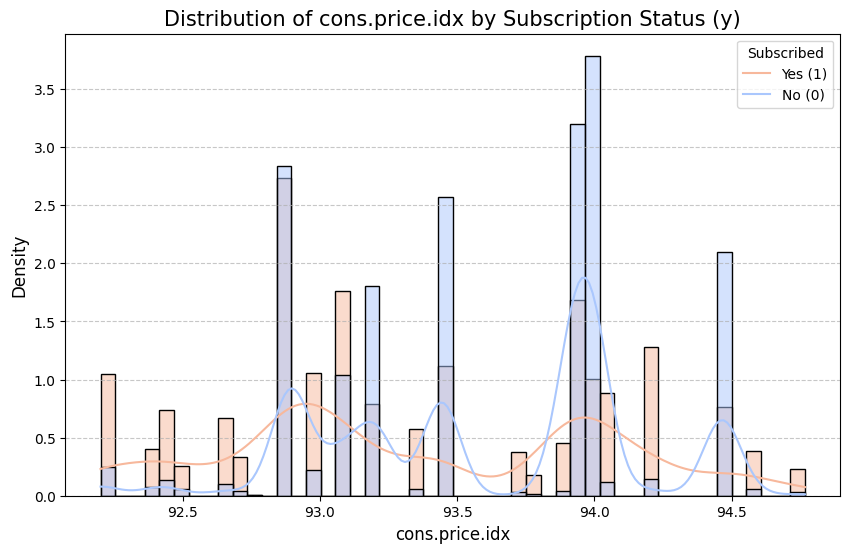


--- Impact of 'cons.conf.idx' for 'y' ---


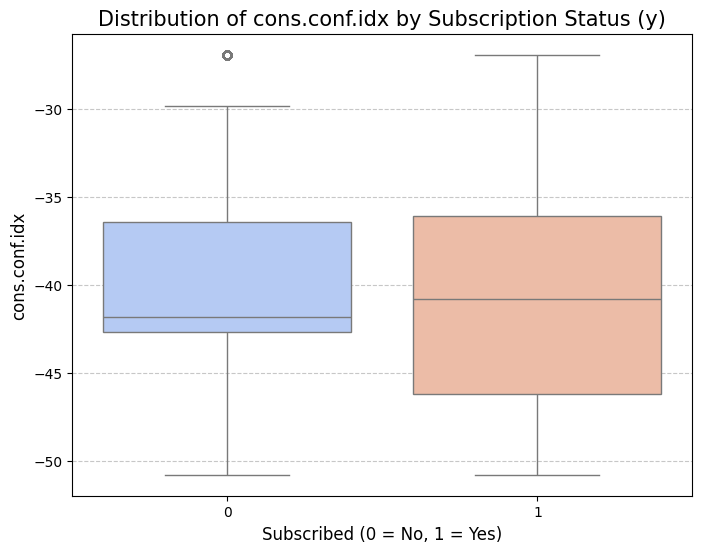

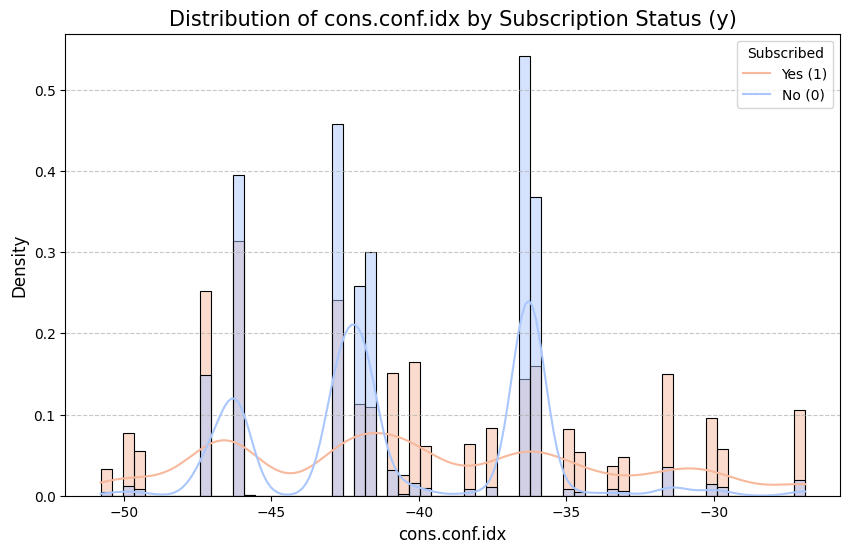


--- Impact of 'euribor3m' for 'y' ---


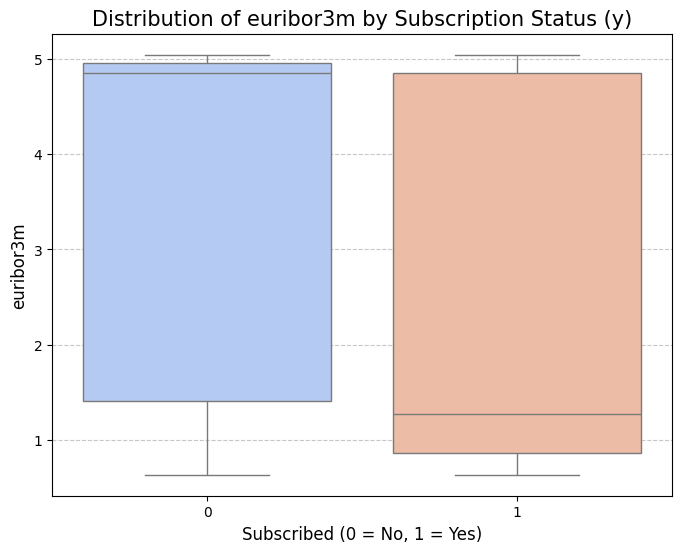

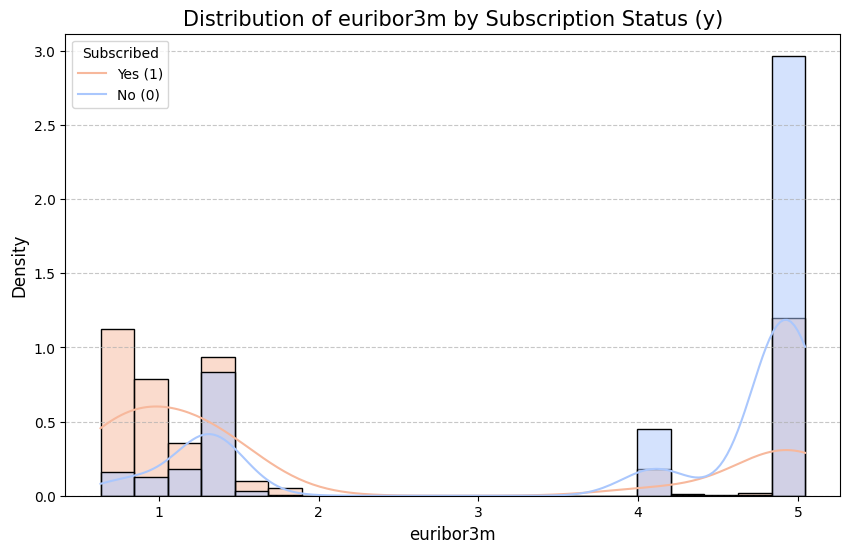


--- Impact of 'nr.employed' for 'y' ---


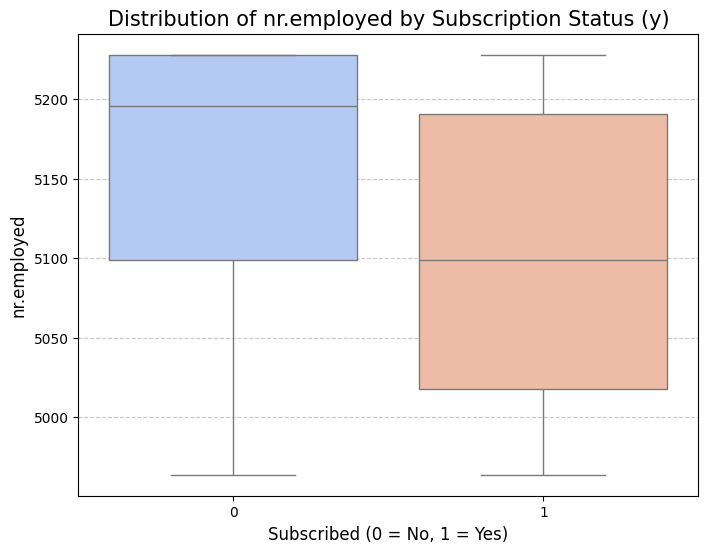

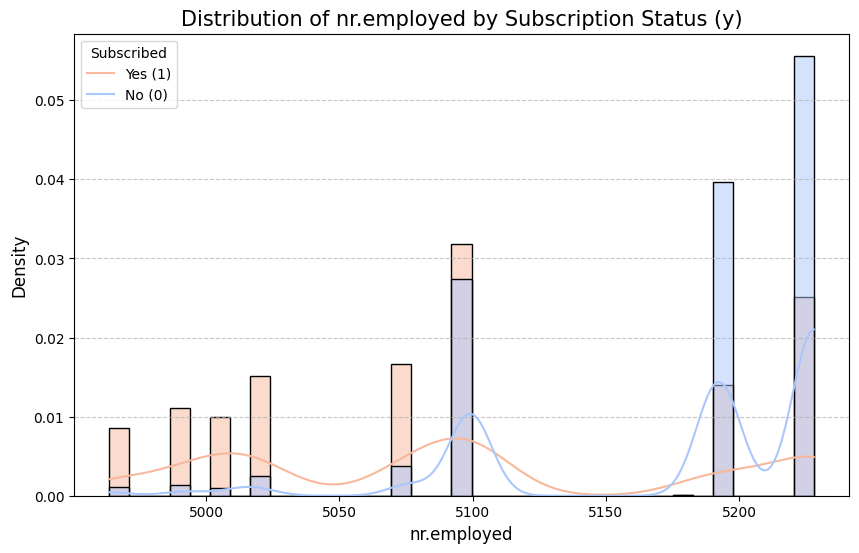

In [21]:
for col in numerical_features_to_analyze:
    print(f"\n--- Impact of '{col}' for 'y' ---")
        
    # Box Plots
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='y', y=col, data=df, hue='y', palette="coolwarm", legend=False)
    plt.title(f'Distribution of {col} by Subscription Status (y)', fontsize=15)
    plt.xlabel('Subscribed (0 = No, 1 = Yes)', fontsize=12)
    plt.ylabel(col, fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Histograms
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=col, hue='y', kde=True, stat="density", common_norm=False, palette="coolwarm")
    plt.title(f'Distribution of {col} by Subscription Status (y)', fontsize=15)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(title='Subscribed', labels=['Yes (1)', 'No (0)'])
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

### Making columns categorical
We are doing it for optimization sake.

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38213 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             38213 non-null  int64   
 1   job             38213 non-null  object  
 2   marital         38213 non-null  object  
 3   education       38213 non-null  object  
 4   default         38213 non-null  object  
 5   housing         38213 non-null  object  
 6   loan            38213 non-null  object  
 7   contact         38213 non-null  object  
 8   month           38213 non-null  object  
 9   day_of_week     38213 non-null  object  
 10  campaign        38213 non-null  int64   
 11  previous        38213 non-null  int64   
 12  poutcome        38213 non-null  object  
 13  emp.var.rate    38213 non-null  float64 
 14  cons.price.idx  38213 non-null  float64 
 15  cons.conf.idx   38213 non-null  float64 
 16  euribor3m       38213 non-null  float64 
 17  nr.employed     3

In [23]:
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38213 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             38213 non-null  int64   
 1   job             38213 non-null  category
 2   marital         38213 non-null  category
 3   education       38213 non-null  category
 4   default         38213 non-null  category
 5   housing         38213 non-null  category
 6   loan            38213 non-null  category
 7   contact         38213 non-null  category
 8   month           38213 non-null  category
 9   day_of_week     38213 non-null  category
 10  campaign        38213 non-null  int64   
 11  previous        38213 non-null  int64   
 12  poutcome        38213 non-null  category
 13  emp.var.rate    38213 non-null  float64 
 14  cons.price.idx  38213 non-null  float64 
 15  cons.conf.idx   38213 non-null  float64 
 16  euribor3m       38213 non-null  float64 
 17  nr.employed     3

### Dataset balance
- 0 = approx. 89%
- 1 = approx. 11%

In [24]:
print(df["y"].value_counts())

y
0    33960
1     4253
Name: count, dtype: int64


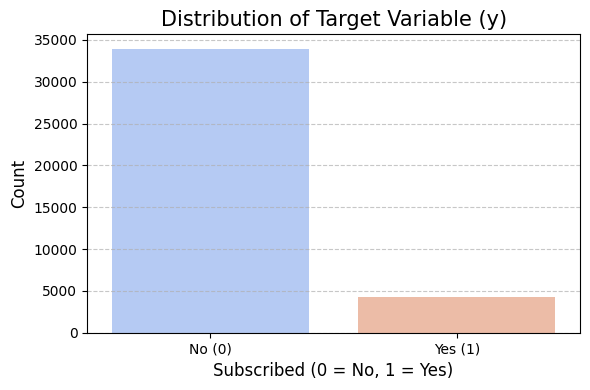

In [25]:
# Plotting the distribution of the target variable 'y'
plt.figure(figsize=(6, 4))
sns.countplot(hue='y', x='y', data=df, palette='coolwarm', legend=False)
plt.title('Distribution of Target Variable (y)', fontsize=15)
plt.xlabel('Subscribed (0 = No, 1 = Yes)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['No (0)', 'Yes (1)'], fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Checking corelation

y                 1.000000
previous          0.221248
cons.conf.idx     0.051235
age               0.029902
campaign         -0.065110
cons.price.idx   -0.132668
emp.var.rate     -0.292015
euribor3m        -0.300402
nr.employed      -0.347757
Name: y, dtype: float64


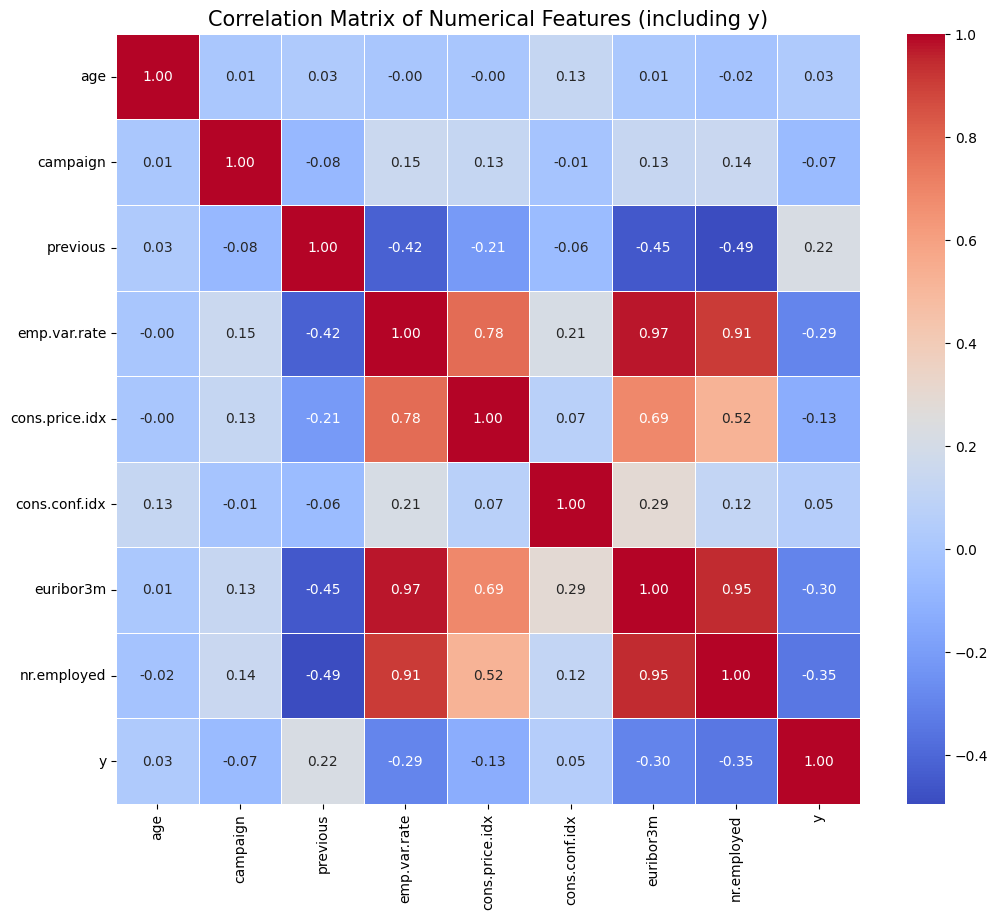

In [26]:
# Corelation of numerical features with target variable 'y'
# We choose only numerical columns and the target variable 'y'
numerical_and_target_for_corr = numerical_features_to_analyze + ['y']

# Usuwamy kolumny, które mogłyby nie istnieć (np. 'duration' jeśli ją usunąłeś)
existing_cols_for_corr = [col for col in numerical_and_target_for_corr if col in df.columns]

df_subset_for_corr = df[existing_cols_for_corr].copy()

correlation_with_target = df_subset_for_corr.corr()['y'].sort_values(ascending=False)
print(correlation_with_target)

# Correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df_subset_for_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features (including y)', fontsize=15)
plt.show()

### One Hot Encoding

In [27]:
# Get all categorical columns
categorical_columns = df.select_dtypes(include=['category']).columns

# One-hot encoding for categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

df_encoded.head()

,age,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_blue-collar,...,contact_telephone,month_low_conv,month_mid_conv,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,pdays_contact_1
0,56,1,0,1.1,93.994,-36.4,4.857,5191.0,0,False,...,True,True,False,True,False,False,False,True,False,False
1,57,1,0,1.1,93.994,-36.4,4.857,5191.0,0,False,...,True,True,False,True,False,False,False,True,False,False
2,37,1,0,1.1,93.994,-36.4,4.857,5191.0,0,False,...,True,True,False,True,False,False,False,True,False,False
3,40,1,0,1.1,93.994,-36.4,4.857,5191.0,0,False,...,True,True,False,True,False,False,False,True,False,False
4,56,1,0,1.1,93.994,-36.4,4.857,5191.0,0,False,...,True,True,False,True,False,False,False,True,False,False


In [28]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38213 entries, 0 to 41187
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            38213 non-null  int64  
 1   campaign                       38213 non-null  int64  
 2   previous                       38213 non-null  int64  
 3   emp.var.rate                   38213 non-null  float64
 4   cons.price.idx                 38213 non-null  float64
 5   cons.conf.idx                  38213 non-null  float64
 6   euribor3m                      38213 non-null  float64
 7   nr.employed                    38213 non-null  float64
 8   y                              38213 non-null  int64  
 9   job_blue-collar                38213 non-null  bool   
 10  job_entrepreneur               38213 non-null  bool   
 11  job_housemaid                  38213 non-null  bool   
 12  job_management                 38213 non-null  bool

### Splitting data

In [29]:
X = df_encoded.drop(columns=['y'])
y = df_encoded['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, stratify=y)

### Scaling

In [30]:
# Numerical features
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()
scaler.fit(X_train[numerical_features])

# Transformation of numerical columns at X_train and X_test
# NumPy array conversion to DataFrame
X_train_scaled_numerical = scaler.transform(X_train[numerical_features])
X_test_scaled_numerical = scaler.transform(X_test[numerical_features])

# Update X_train and X_test data frames with scaled values.
# Create new data frames with scaled columns, keeping column names
X_train_scaled_numerical_df = pd.DataFrame(X_train_scaled_numerical, columns=numerical_features, index=X_train.index)
X_test_scaled_numerical_df = pd.DataFrame(X_test_scaled_numerical, columns=numerical_features, index=X_test.index)

# Replace the original numerical columns with their scaled versions
for col in numerical_features:
    X_train[col] = X_train_scaled_numerical_df[col]
    X_test[col] = X_test_scaled_numerical_df[col]

# Modeling

### Logistic Regression 

In [31]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000, 2000]
}

lr = LogisticRegression(random_state=17, class_weight='balanced')

grid_search_lr = GridSearchCV(
    estimator=lr,
    param_grid=param_grid_lr,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=2
)
grid_search_lr.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eks

[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s


/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eks

[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.1s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.1s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.1s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.1s
[CV] END .....C=0.01, max_iter=1000, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=2000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=2000, penalty=l1, solver=liblinear; total time=   0.1s


/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eks

[CV] END C=0.01, max_iter=2000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=2000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=2000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END C=0.01, max_iter=2000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=2000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=2000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=2000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END C=0.01, max_iter=2000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .....C=0.01, max_iter=2000, penalty=l1, solver=saga; total time=   0.2s
[CV] END .....C=0.01, max_iter=2000, penalty=l1, solver=saga; total time=   0.2s


/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eks

[CV] END .....C=0.01, max_iter=2000, penalty=l2, solver=saga; total time=   0.1s
[CV] END .....C=0.01, max_iter=2000, penalty=l2, solver=saga; total time=   0.1s
[CV] END .....C=0.01, max_iter=2000, penalty=l2, solver=saga; total time=   0.1s
[CV] END .....C=0.01, max_iter=2000, penalty=l1, solver=saga; total time=   0.3s
[CV] END .....C=0.01, max_iter=2000, penalty=l2, solver=saga; total time=   0.1s
[CV] END .....C=0.01, max_iter=2000, penalty=l2, solver=saga; total time=   0.1s
[CV] END .....C=0.01, max_iter=2000, penalty=l1, solver=saga; total time=   0.3s


/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eks

[CV] END .....C=0.01, max_iter=1000, penalty=l1, solver=saga; total time=   0.7s
[CV] END .C=0.1, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END .C=0.1, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END .C=0.1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .....C=0.01, max_iter=2000, penalty=l1, solver=saga; total time=   0.6s
[CV] END .C=0.1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.1, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.5s


/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eks

[CV] END .C=0.1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.1, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END .C=0.1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.1, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.5s


/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eks

[CV] END ......C=0.1, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......C=0.1, max_iter=1000, penalty=l2, solver=saga; total time=   0.2s
[CV] END ......C=0.1, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......C=0.1, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......C=0.1, max_iter=1000, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......C=0.1, max_iter=1000, penalty=l1, solver=saga; total time=   0.6s
[CV] END .C=0.1, max_iter=2000, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END ......C=0.1, max_iter=1000, penalty=l1, solver=saga; total time=   0.8s
[CV] END ......C=0.1, max_iter=1000, penalty=l1, solver=saga; total time=   0.8s
[CV] END ......C=0.1, max_iter=1000, penalty=l1, solver=saga; total time=   0.8s


/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eks

[CV] END ......C=0.1, max_iter=1000, penalty=l1, solver=saga; total time=   0.9s
[CV] END .C=0.1, max_iter=2000, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END .C=0.1, max_iter=2000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.1, max_iter=2000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.1, max_iter=2000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.1, max_iter=2000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.1, max_iter=2000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.1, max_iter=2000, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END .C=0.1, max_iter=2000, penalty=l1, solver=liblinear; total time=   0.4s


/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eks

[CV] END .C=0.1, max_iter=2000, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END ......C=0.1, max_iter=2000, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......C=0.1, max_iter=2000, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......C=0.1, max_iter=2000, penalty=l2, solver=saga; total time=   0.3s


/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eks

[CV] END ......C=0.1, max_iter=2000, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......C=0.1, max_iter=2000, penalty=l2, solver=saga; total time=   0.3s
[CV] END ......C=0.1, max_iter=2000, penalty=l1, solver=saga; total time=   0.6s
[CV] END ......C=0.1, max_iter=2000, penalty=l1, solver=saga; total time=   0.7s
[CV] END ......C=0.1, max_iter=2000, penalty=l1, solver=saga; total time=   0.7s
[CV] END ......C=0.1, max_iter=2000, penalty=l1, solver=saga; total time=   0.7s


/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eks

[CV] END ...C=1, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END ...C=1, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END ......C=0.1, max_iter=2000, penalty=l1, solver=saga; total time=   0.8s
[CV] END ...C=1, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s


/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eks

[CV] END ...C=1, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.4s


/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eks

[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   0.7s
[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   0.7s
[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   0.6s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   0.5s
[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   0.7s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   0.5s
[CV] END ........C=1, max_iter=1000, penalty=l1, solver=saga; total time=   0.7s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   0.5s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   0.4s
[CV] END ...C=1, max_iter=2000, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END ...C=1, max_iter=2000, penalty=l1, solver=liblinear; total time=   0.5s


/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eks

[CV] END ...C=1, max_iter=2000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=2000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=   0.6s
[CV] END ...C=1, max_iter=2000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=2000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=2000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=2000, penalty=l1, solver=liblinear; total time=   0.4s


/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eks

[CV] END ...C=1, max_iter=2000, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END ...C=1, max_iter=2000, penalty=l1, solver=liblinear; total time=   0.5s


/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eks

[CV] END ........C=1, max_iter=2000, penalty=l2, solver=saga; total time=   0.4s
[CV] END ........C=1, max_iter=2000, penalty=l1, solver=saga; total time=   0.6s
[CV] END ........C=1, max_iter=2000, penalty=l2, solver=saga; total time=   0.4s
[CV] END ........C=1, max_iter=2000, penalty=l1, solver=saga; total time=   0.7s
[CV] END ........C=1, max_iter=2000, penalty=l1, solver=saga; total time=   0.7s
[CV] END ........C=1, max_iter=2000, penalty=l1, solver=saga; total time=   0.7s
[CV] END ........C=1, max_iter=2000, penalty=l2, solver=saga; total time=   0.5s
[CV] END ........C=1, max_iter=2000, penalty=l2, solver=saga; total time=   0.5s
[CV] END ........C=1, max_iter=2000, penalty=l2, solver=saga; total time=   0.5s
[CV] END ........C=1, max_iter=2000, penalty=l1, solver=saga; total time=   0.8s


/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eks

[CV] END ..C=10, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END ..C=10, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END ..C=10, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s


/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END ..C=10, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.5s


/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eks

[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   0.6s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   0.7s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   0.7s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   0.5s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   0.5s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   0.7s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   0.5s
[CV] END ..C=10, max_iter=2000, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   0.5s


/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eks

[CV] END .......C=10, max_iter=1000, penalty=l2, solver=saga; total time=   0.6s
[CV] END ..C=10, max_iter=2000, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END ..C=10, max_iter=2000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .......C=10, max_iter=1000, penalty=l1, solver=saga; total time=   0.9s
[CV] END ..C=10, max_iter=2000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=2000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=2000, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END ..C=10, max_iter=2000, penalty=l1, solver=liblinear; total time=   0.4s


/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eks

[CV] END ..C=10, max_iter=2000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=10, max_iter=2000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ..C=10, max_iter=2000, penalty=l1, solver=liblinear; total time=   0.5s


/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eks

[CV] END .......C=10, max_iter=2000, penalty=l1, solver=saga; total time=   0.7s
[CV] END .......C=10, max_iter=2000, penalty=l2, solver=saga; total time=   0.5s
[CV] END .......C=10, max_iter=2000, penalty=l1, solver=saga; total time=   0.8s
[CV] END .......C=10, max_iter=2000, penalty=l2, solver=saga; total time=   0.5s
[CV] END .......C=10, max_iter=2000, penalty=l2, solver=saga; total time=   0.5s
[CV] END .......C=10, max_iter=2000, penalty=l1, solver=saga; total time=   0.8s
[CV] END .......C=10, max_iter=2000, penalty=l2, solver=saga; total time=   0.6s
[CV] END .......C=10, max_iter=2000, penalty=l1, solver=saga; total time=   0.8s
[CV] END .......C=10, max_iter=2000, penalty=l2, solver=saga; total time=   0.5s
[CV] END .C=100, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END .C=100, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END .......C=10, max_iter=2000, penalty=l1, solver=saga; total time=   0.9s
[CV] END .C=100, max_iter=10

/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eks

[CV] END .C=100, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=100, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=100, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END .C=100, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END .C=100, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.5s


/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eks

[CV] END ......C=100, max_iter=1000, penalty=l2, solver=saga; total time=   0.4s
[CV] END ......C=100, max_iter=1000, penalty=l1, solver=saga; total time=   0.6s
[CV] END ......C=100, max_iter=1000, penalty=l1, solver=saga; total time=   0.7s
[CV] END ......C=100, max_iter=1000, penalty=l2, solver=saga; total time=   0.5s
[CV] END ......C=100, max_iter=1000, penalty=l2, solver=saga; total time=   0.5s
[CV] END ......C=100, max_iter=1000, penalty=l2, solver=saga; total time=   0.5s
[CV] END ......C=100, max_iter=1000, penalty=l1, solver=saga; total time=   0.8s
[CV] END ......C=100, max_iter=1000, penalty=l2, solver=saga; total time=   0.6s
[CV] END ......C=100, max_iter=1000, penalty=l1, solver=saga; total time=   0.8s
[CV] END .C=100, max_iter=2000, penalty=l1, solver=liblinear; total time=   0.5s


/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eks

[CV] END ......C=100, max_iter=1000, penalty=l1, solver=saga; total time=   0.9s
[CV] END .C=100, max_iter=2000, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END .C=100, max_iter=2000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=100, max_iter=2000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=100, max_iter=2000, penalty=l2, solver=liblinear; total time=   0.1s


/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eks

[CV] END .C=100, max_iter=2000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=100, max_iter=2000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=100, max_iter=2000, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END .C=100, max_iter=2000, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END .C=100, max_iter=2000, penalty=l1, solver=liblinear; total time=   0.5s


/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eks

[CV] END ......C=100, max_iter=2000, penalty=l1, solver=saga; total time=   0.6s
[CV] END ......C=100, max_iter=2000, penalty=l1, solver=saga; total time=   0.6s
[CV] END ......C=100, max_iter=2000, penalty=l1, solver=saga; total time=   0.6s
[CV] END ......C=100, max_iter=2000, penalty=l1, solver=saga; total time=   0.7s
[CV] END ......C=100, max_iter=2000, penalty=l2, solver=saga; total time=   0.4s
[CV] END ......C=100, max_iter=2000, penalty=l2, solver=saga; total time=   0.4s
[CV] END ......C=100, max_iter=2000, penalty=l2, solver=saga; total time=   0.4s
[CV] END ......C=100, max_iter=2000, penalty=l2, solver=saga; total time=   0.4s
[CV] END ......C=100, max_iter=2000, penalty=l1, solver=saga; total time=   0.7s
[CV] END ......C=100, max_iter=2000, penalty=l2, solver=saga; total time=   0.4s


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=17),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'max_iter': [1000, 2000],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='roc_auc', verbose=2)

In [32]:
print("Best hyperparameters for Logistic Regression:")
print(grid_search_lr.best_params_)
print(f"Best AUC score (on validation set): {grid_search_lr.best_score_:.4f}")

best_lr_model = grid_search_lr.best_estimator_
y_pred_lr = best_lr_model.predict(X_test)
y_pred_proba_lr = best_lr_model.predict_proba(X_test)[:, 1]

Best hyperparameters for Logistic Regression:
{'C': 10, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}
Best AUC score (on validation set): 0.7855


/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eksploracja-i-Wizualizacja-Danych/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tomasz/Developer/EWD---Eks

In [33]:
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {accuracy_lr:.4f}")

auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
print(f"AUC ROC: {auc_lr:.4f}")

print("\nConfusion Matrix (Final Model):")
cm_final = confusion_matrix(y_test, y_pred_lr)
print(cm_final)
tn_final, fp_final, fn_final, tp_final = cm_final.ravel()
print(f"True Negatives: {tn_final}, False Positives: {fp_final}")
print(f"False Negatives: {fn_final}, True Positives: {tp_final}")

print("\n"+classification_report(y_test, y_pred_lr, target_names=['No (0)', 'Yes (1)']))

Accuracy: 0.8037
AUC ROC: 0.7850

Confusion Matrix (Final Model):
[[5588 1204]
 [ 296  555]]
True Negatives: 5588, False Positives: 1204
False Negatives: 296, True Positives: 555

              precision    recall  f1-score   support

      No (0)       0.95      0.82      0.88      6792
     Yes (1)       0.32      0.65      0.43       851

    accuracy                           0.80      7643
   macro avg       0.63      0.74      0.65      7643
weighted avg       0.88      0.80      0.83      7643



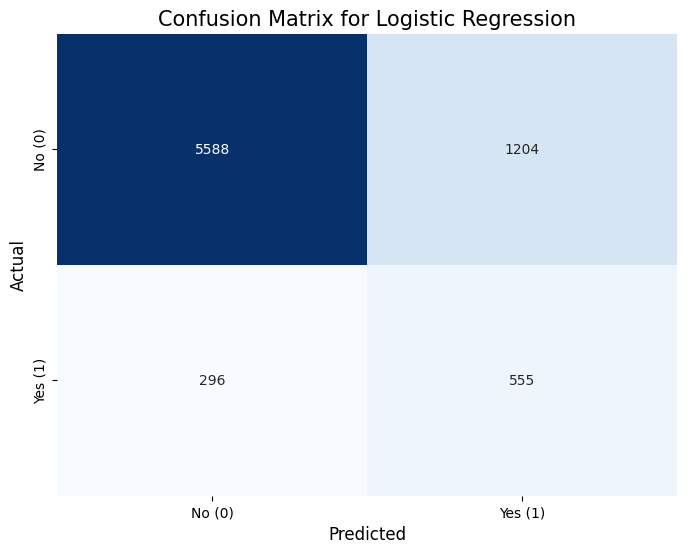

In [34]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No (0)', 'Yes (1)'], yticklabels=['No (0)', 'Yes (1)'])
plt.title('Confusion Matrix for Logistic Regression', fontsize=15)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()

                          Feature  Importance
34                pdays_contact_1    1.444049
3                    emp.var.rate    1.277850
26                 month_low_conv    1.126609
25              contact_telephone    0.975253
4                  cons.price.idx    0.870698
27                 month_mid_conv    0.786788
7                     nr.employed    0.548356
32           poutcome_nonexistent    0.501894
33               poutcome_success    0.501142
12                    job_retired    0.421206
6                       euribor3m    0.418036
15                    job_student    0.408796
5                   cons.conf.idx    0.294197
21    education_university.degree    0.191409
22                default_unknown    0.190772
10                  job_housemaid    0.175991
28                day_of_week_mon    0.111963
1                        campaign    0.090379
14                   job_services    0.089809
31                day_of_week_wed    0.074292
19          education_high.school 

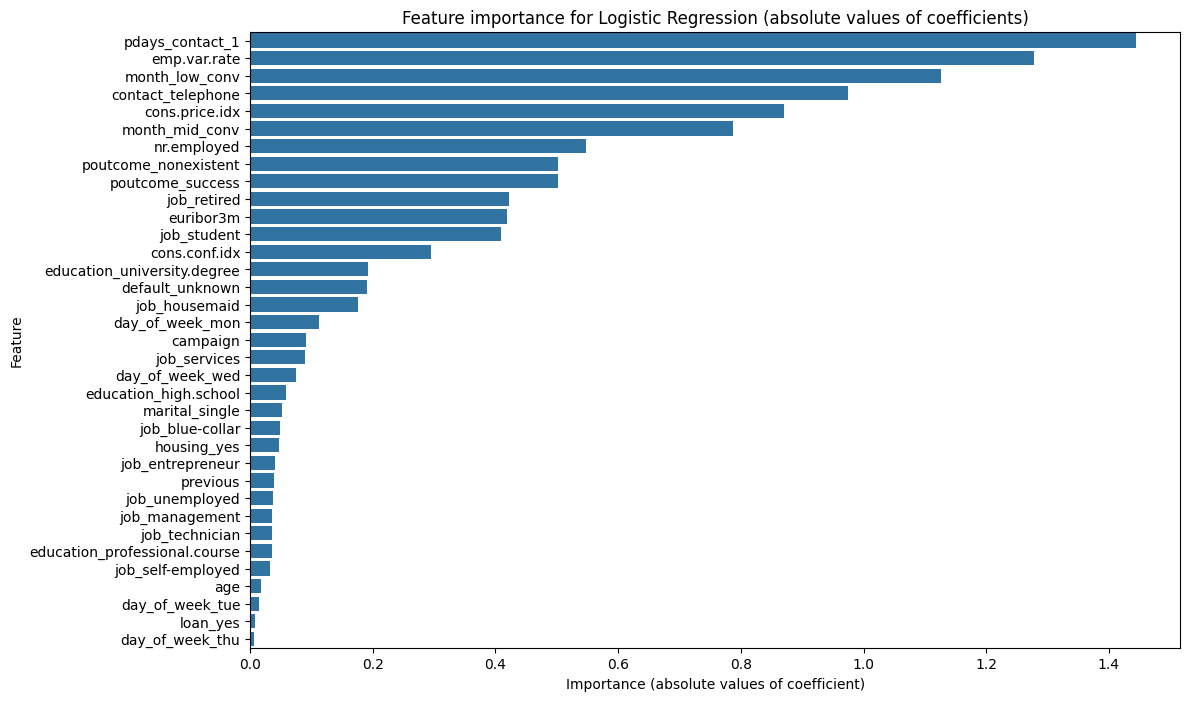

In [35]:
columns_names = X_train.columns
coefficients = best_lr_model.coef_[0]

feature_importance_df_lr = pd.DataFrame({
    'Feature': columns_names,
    # Using absolute values of coefficients
    'Importance': abs(coefficients)
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df_lr)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_lr)
plt.title('Feature importance for Logistic Regression (absolute values of coefficients)')
plt.xlabel('Importance (absolute values of coefficient)')
plt.ylabel('Feature')
plt.show()

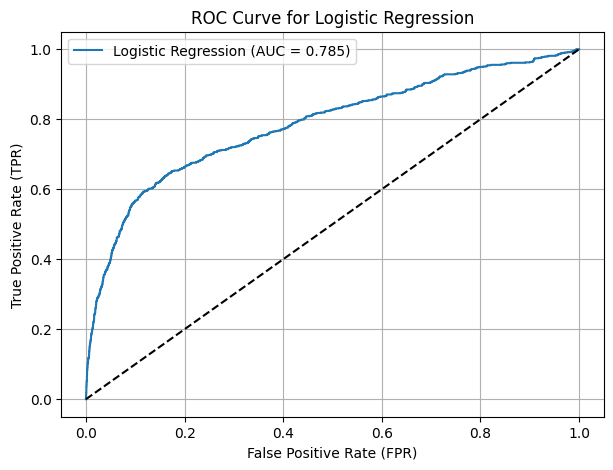

In [36]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_proba_lr)
plt.figure(figsize=(7,5))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.3f})')
plt.plot([0, 1], [0, 1], 'k--') # Line of random chance
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Logistic Regression')
plt.legend()
plt.grid(True)
plt.show()

### Random Forest

In [37]:
param_grid_rf = {
    # Amount of trees in the forest
    'n_estimators': [100, 200, 300, 400],
    # Max depth of the tree - none - no limit
    'max_depth': [10, 20, 30, None],
    # Minimum number of samples to split an internal node
    'min_samples_split': [2, 5, 10],
    # Minimum number of samples to be at a leaf node
    'min_samples_leaf': [1, 2, 4],
    # Number of features to consider when looking for the best split
    'max_features': ['sqrt', 'log2']
}


rf = RandomForestClassifier(random_state=17, class_weight='balanced')

random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid_rf,
    n_iter=20,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=17
)

random_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.4s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.4s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   3.7s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   3.8s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   3.8s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   3.9s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   3.9s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estima

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=17),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400]},
                   random_state=17, scoring='roc_auc', verbose=2)

In [38]:
print(random_search_rf.best_params_)
print(f"Best AUC score (on validation set): {random_search_rf.best_score_:.4f}")

random_rf_model = random_search_rf.best_estimator_
y_pred_rf = random_rf_model.predict(X_test)
y_pred_proba_rf = random_rf_model.predict_proba(X_test)[:, 1]

{'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10}
Best AUC score (on validation set): 0.7978


In [39]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy_rf:.4f}")

auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f"AUC ROC: {auc_rf:.4f}")

print("\nConfusion Matrix (Final Model):")
cm_final = confusion_matrix(y_test, y_pred_rf)
print(cm_final)
tn_final, fp_final, fn_final, tp_final = cm_final.ravel()
print(f"True Negatives: {tn_final}, False Positives: {fp_final}")
print(f"False Negatives: {fn_final}, True Positives: {tp_final}")

print("\n"+classification_report(y_test, y_pred_rf, target_names=['No (0)', 'Yes (1)']))

Accuracy: 0.8556
AUC ROC: 0.8033

Confusion Matrix (Final Model):
[[6019  773]
 [ 331  520]]
True Negatives: 6019, False Positives: 773
False Negatives: 331, True Positives: 520

              precision    recall  f1-score   support

      No (0)       0.95      0.89      0.92      6792
     Yes (1)       0.40      0.61      0.49       851

    accuracy                           0.86      7643
   macro avg       0.68      0.75      0.70      7643
weighted avg       0.89      0.86      0.87      7643



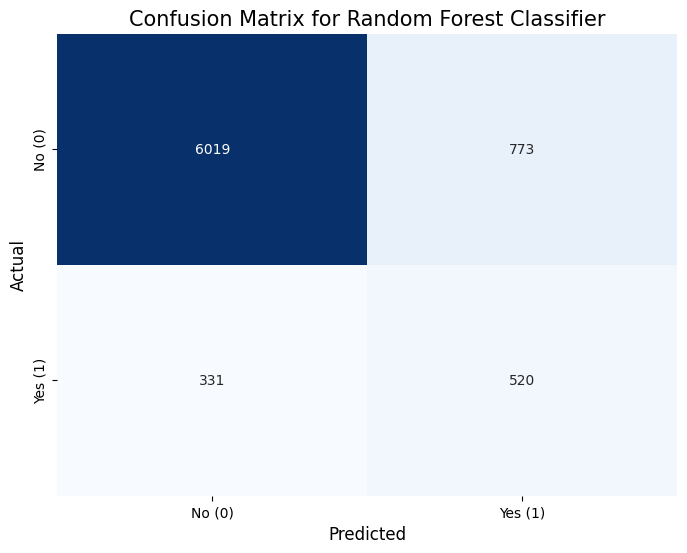

In [40]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No (0)', 'Yes (1)'], yticklabels=['No (0)', 'Yes (1)'])
plt.title('Confusion Matrix for Random Forest Classifier', fontsize=15)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()

                          Feature  Importance
6                       euribor3m    0.186625
7                     nr.employed    0.171906
3                    emp.var.rate    0.120865
5                   cons.conf.idx    0.074384
26                 month_low_conv    0.060272
4                  cons.price.idx    0.059800
34                pdays_contact_1    0.056115
0                             age    0.041130
33               poutcome_success    0.040874
25              contact_telephone    0.024798
1                        campaign    0.023321
32           poutcome_nonexistent    0.019910
2                        previous    0.015385
22                default_unknown    0.013502
27                 month_mid_conv    0.008081
21    education_university.degree    0.007543
8                 job_blue-collar    0.007452
28                day_of_week_mon    0.006244
18                 marital_single    0.005614
23                    housing_yes    0.005430
29                day_of_week_thu 

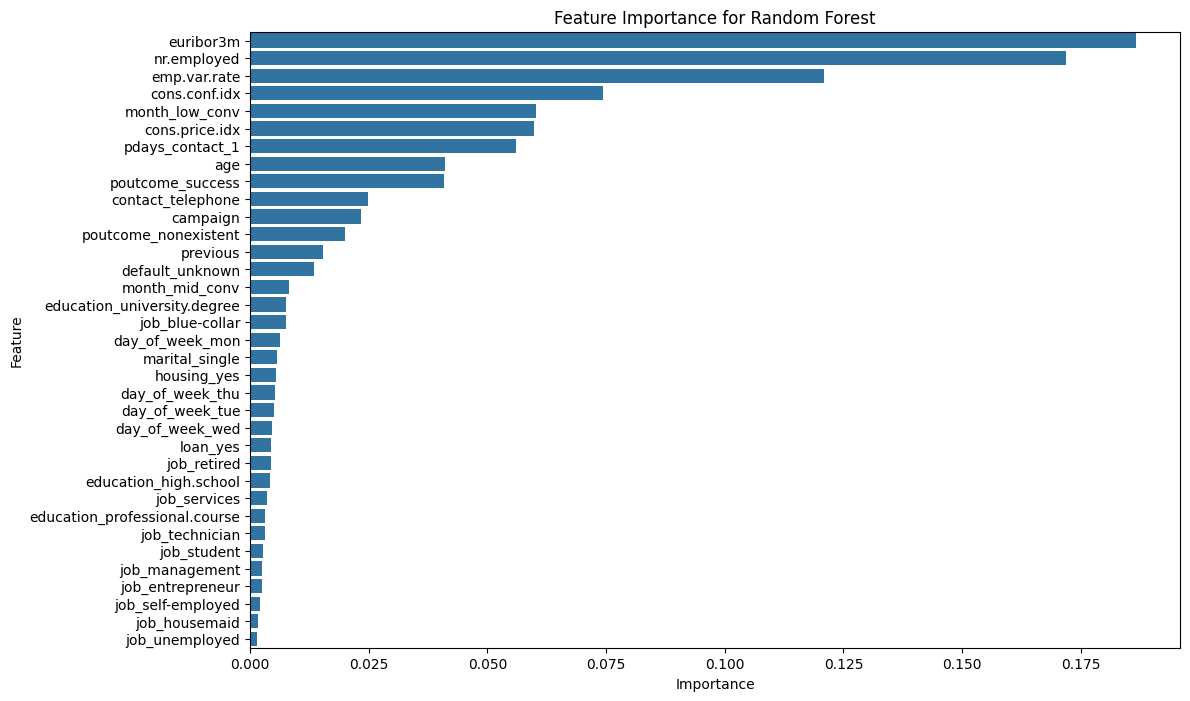

In [41]:
columns_names = X_train.columns
importances = random_rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': columns_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance for Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

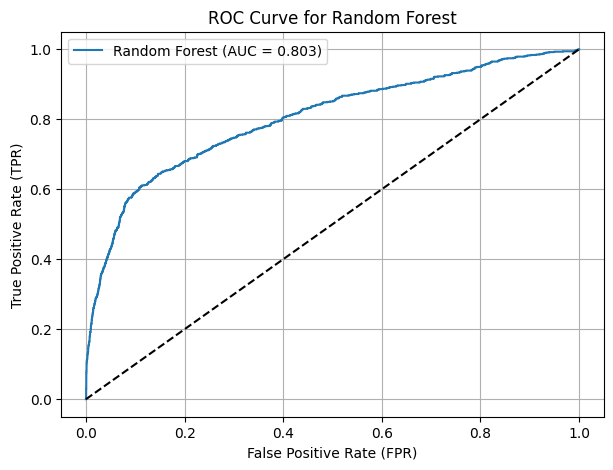

In [42]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_proba_rf)
plt.figure(figsize=(7,5))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})')
plt.plot([0, 1], [0, 1], 'k--') # Line of random chance
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Random Forest')
plt.legend()
plt.grid(True)
plt.show()

### Gradient Boosting

In [43]:
# Calculate weight for samples (sample_weight) to balance the classes
sample_weights_gb = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

param_grid_gb = {
    # Amount of trees
    'n_estimators': [100, 200, 300],
    # Learning rate
    'learning_rate': [0.01, 0.1, 0.2],
    # Max depth of the tree
    'max_depth': [3, 5, 7],
    # Max fraction used to train each tree
    'subsample': [0.7, 0.8, 0.9, 1.0],
    # Minimum number of samples to split an internal node
    'min_samples_split': [2, 5, 10],
    # Minimum number of samples to be at a leaf node
    'min_samples_leaf': [1, 2, 4]
}

gb = GradientBoostingClassifier(random_state=17)

random_search_gb = RandomizedSearchCV(
    estimator=gb,
    param_distributions=param_grid_gb,
    n_iter=20,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2,
    random_state=17
)

random_search_gb.fit(X_train, y_train, sample_weight=sample_weights_gb)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=200, subsample=0.7; total time=   3.0s
[CV] END learning_rate=0.2, max_depth=7, min_samples_leaf=4, min_samples_split=2, n_estimators=100, subsample=0.7; total time=   3.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=200, subsample=0.7; total time=   3.0s
[CV] END learning_rate=0.2, max_depth=7, min_samples_leaf=4, min_samples_split=2, n_estimators=100, subsample=0.7; total time=   3.2s
[CV] END learning_rate=0.2, max_depth=7, min_samples_leaf=4, min_samples_split=2, n_estimators=100, subsample=0.7; total time=   3.3s
[CV] END learning_rate=0.2, max_depth=7, min_samples_leaf=4, min_samples_split=2, n_estimators=100, subsample=0.7; total time=   3.3s
[CV] END learning_rate=0.2, max_depth=7, min_samples_leaf=4, min_samples_split=2, n_estimators=100, subsample=0.7; total time=   3.3

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=17),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.7, 0.8, 0.9, 1.0]},
                   random_state=17, scoring='roc_auc', verbose=2)

In [44]:
print(random_search_gb.best_params_)
print(f"Best AUC score (on validation set): {random_search_gb.best_score_:.4f}")

random_gb_model = random_search_gb.best_estimator_
y_pred_gb = random_gb_model.predict(X_test)
y_pred_proba_gb = random_gb_model.predict_proba(X_test)[:, 1]

{'subsample': 0.8, 'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 5, 'learning_rate': 0.01}
Best AUC score (on validation set): 0.7993


In [45]:
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"Accuracy: {accuracy_gb:.4f}")

auc_gb = roc_auc_score(y_test, y_pred_proba_gb)
print(f"AUC ROC: {auc_gb:.4f}")

print("\nConfusion Matrix (Final Model):")
cm_final = confusion_matrix(y_test, y_pred_gb)
print(cm_final)
tn_final, fp_final, fn_final, tp_final = cm_final.ravel()
print(f"True Negatives: {tn_final}, False Positives: {fp_final}")
print(f"False Negatives: {fn_final}, True Positives: {tp_final}")

print("\n"+classification_report(y_test, y_pred_gb, target_names=['No (0)', 'Yes (1)']))

Accuracy: 0.8383
AUC ROC: 0.8025

Confusion Matrix (Final Model):
[[5861  931]
 [ 305  546]]
True Negatives: 5861, False Positives: 931
False Negatives: 305, True Positives: 546

              precision    recall  f1-score   support

      No (0)       0.95      0.86      0.90      6792
     Yes (1)       0.37      0.64      0.47       851

    accuracy                           0.84      7643
   macro avg       0.66      0.75      0.69      7643
weighted avg       0.89      0.84      0.86      7643



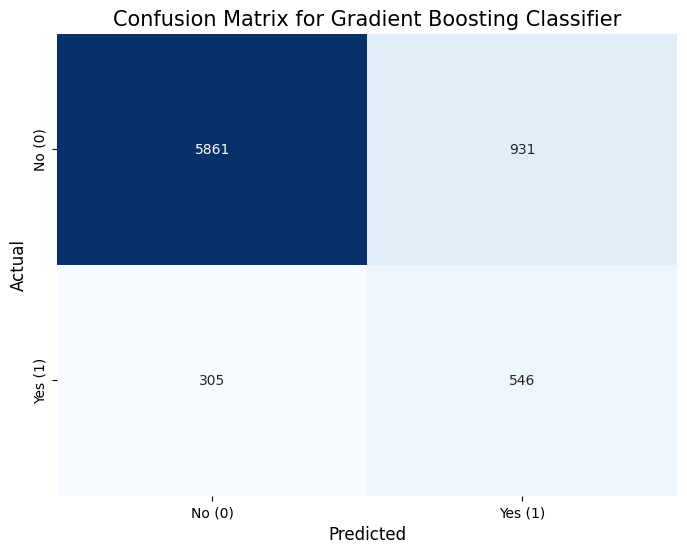

In [46]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No (0)', 'Yes (1)'], yticklabels=['No (0)', 'Yes (1)'])
plt.title('Confusion Matrix for Gradient Boosting Classifier', fontsize=15)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()

                          Feature  Importance
7                     nr.employed    0.551195
26                 month_low_conv    0.125944
6                       euribor3m    0.115272
0                             age    0.032661
5                   cons.conf.idx    0.025374
1                        campaign    0.025075
34                pdays_contact_1    0.021393
25              contact_telephone    0.020334
22                default_unknown    0.011078
4                  cons.price.idx    0.008998
33               poutcome_success    0.005975
21    education_university.degree    0.005934
3                    emp.var.rate    0.005892
2                        previous    0.005481
28                day_of_week_mon    0.005248
32           poutcome_nonexistent    0.004646
30                day_of_week_tue    0.004153
8                 job_blue-collar    0.002372
31                day_of_week_wed    0.002209
9                job_entrepreneur    0.002009
27                 month_mid_conv 

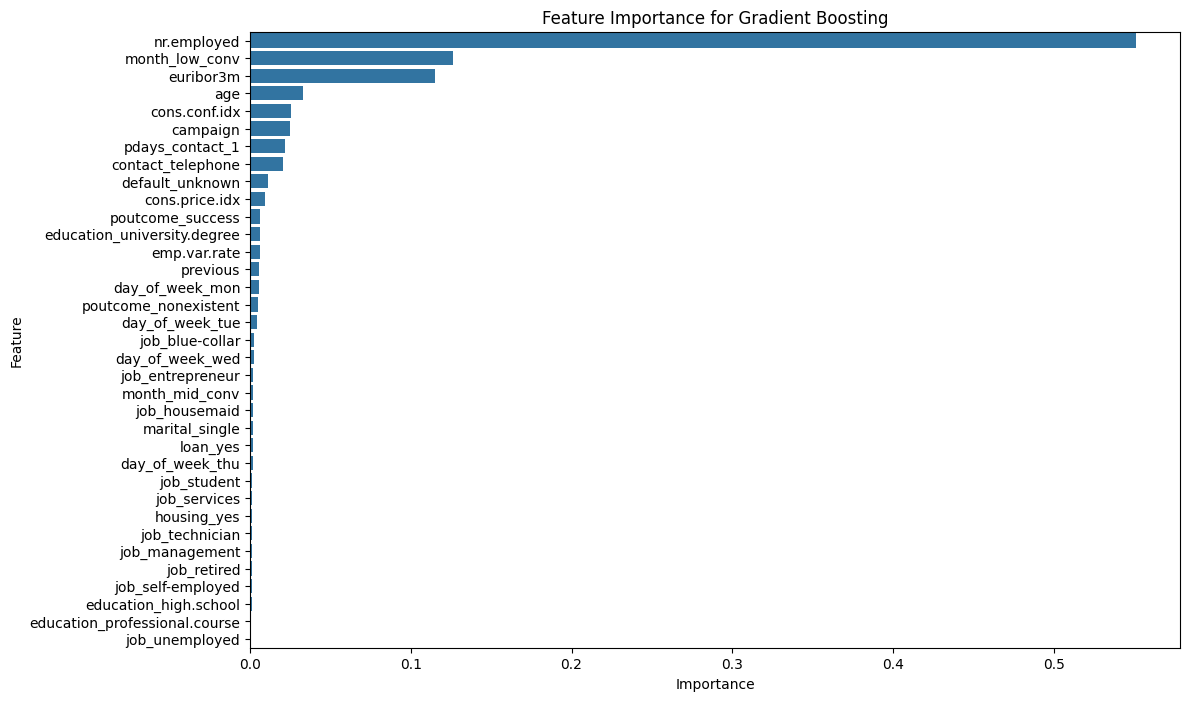

In [47]:
columns_names = X_train.columns
importances = random_gb_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': columns_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance for Gradient Boosting')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

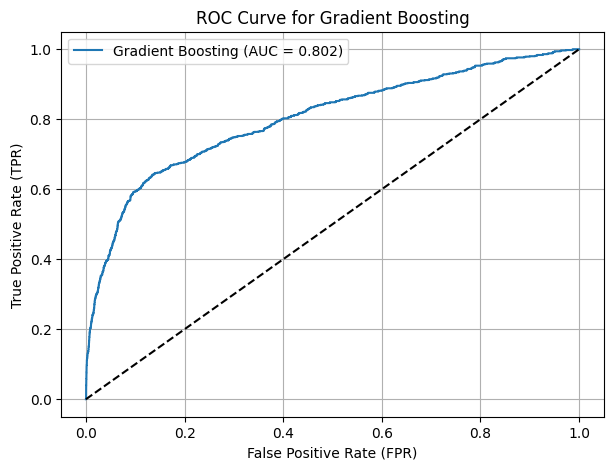

In [48]:
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test, y_pred_proba_gb)
plt.figure(figsize=(7,5))
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {auc_gb:.3f})')
plt.plot([0, 1], [0, 1], 'k--') # Line of random chance
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Gradient Boosting')
plt.legend()
plt.grid(True)
plt.show()